In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)
sys.path.insert(0, ".././0.data-download/scripts/")

from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

import blitzgsea as blitz
import urllib.request

# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


2023-06-19 13:49:57.312121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - Kinase_Perturbations_from_GEO_down
16 - Disease_Signatures_from_GEO_down_2014
17 - Disease_Perturbations_from_GEO_up
18 - Old_CMAP_down
19 - MCF7_Perturbations_from_GEO_up
20 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
21 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
22 - PPI_Hub_Proteins
23 - Disease_Signatures_from_GEO_up_2014
24 - GTEx_Tissue_Expression_Up
25 - L1000_Kinase_and_GPCR_Perturbati

In [4]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("GO_Biological_Process_2017")

In [5]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE/results/weight_matrix_gsea.csv")
signature = pd.read_csv(gene_weight_dir)
print(signature.shape)
signature.head()

(1000, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,FAM50A,-0.000776,-0.182148,-0.145655,0.163493,0.046534,-0.070291,0.066918,0.114472,-0.208144,0.096360
1,CDK6,-0.165700,-0.014118,0.164734,-0.240282,0.022240,-0.109944,-0.101748,-0.018010,-0.000716,-0.031678
2,CDAN1,0.004751,0.209441,0.018309,-0.112892,0.272021,-0.032097,-0.158448,-0.255144,-0.307854,-0.145137
3,GPX4,-0.108087,0.431431,-0.036791,0.042621,0.087107,0.113526,-0.148631,-0.126367,0.008173,0.376883
4,SEPHS2,0.033362,0.249796,-0.038313,-0.293302,0.007984,-0.156843,0.044967,-0.189906,-0.025856,0.144821


In [6]:
# Running GSEA

all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [7]:
# Copying signature dataframe without gene column
neg_signature = signature.iloc[:, 1:].copy()

# Vertically shuffling the data in each column to create a negative control
for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

# Adding gene column back to finalize negative control data
genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

# Running GSEA with negative control data
neg_GSEA_results = []
negative_control = []

range = neg_signature.shape[1]

for col in neg_signature.iloc[:,1:range].columns:
    neg_df = neg_signature.iloc[:,[0,int(col)]]
    neg_result = blitz.gsea(neg_df, library)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [8]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

# merging real and negative control gsea results to single dataframe with column specifying source
all_GSEA_results['source'] = 'real'
neg_GSEA_results['source'] = 'negative control'

combo_gsea_df = pd.concat([all_GSEA_results, neg_GSEA_results])

# saving gsea results as single output file
combo_gsea_dir = pathlib.Path("./results/combined_gsea_results.csv.gz")
combo_gsea_df.to_csv(combo_gsea_dir, compression = 'gzip')


In [9]:
# sort by what you want to evaluate
all_GSEA_results.sort_values(by='nes', ascending = True)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim,source
Term,,,,,,,,,
mitochondrial translational termination (GO:0070126),-0.621920,-5.744199,9.235691e-09,0.000002,0.000002,67,"MRPL48,MRPS15,MRPS23,MRPL23,MRPS24,MRPL18,MRPL...",z_7,real
mitochondrial translational elongation (GO:0070125),-0.606115,-5.565713,2.610834e-08,0.000006,0.000003,67,"MRPL48,MRPS15,MRPS23,MRPL23,MRPS24,MRPL18,MRPL...",z_7,real
mitochondrial translational elongation (GO:0070125),-0.595618,-5.383945,7.287092e-08,0.000018,0.000018,67,"MRPL19,MRPS10,MRPS31,MRPS16,MRPS23,MRPL47,MRPL...",z_3,real
mitochondrial translational termination (GO:0070126),-0.582775,-5.240590,1.600640e-07,0.000040,0.000020,67,"MRPL19,MRPS10,MRPS31,MRPS16,MRPS23,MRPL47,MRPL...",z_3,real
mitochondrial translational elongation (GO:0070125),-0.585209,-5.236813,1.633728e-07,0.000041,0.000041,67,"MRPL14,MRPS17,MRPL33,MRPS24,MRPS5,MRPL36,MRPS1...",z_1,real
...,...,...,...,...,...,...,...,...,...
vascular endothelial growth factor receptor signaling pathway (GO:0048010),0.771231,3.120921,1.802864e-03,0.360785,0.148974,11,"ACTB,ELMO2,ITGAV,RAC1,PTK2,PAK2,BRK1",z_10,real
mitochondrial respiratory chain complex I assembly (GO:0032981),0.517030,3.129997,1.748084e-03,0.352026,0.107010,31,"NDUFB2,NDUFC2,NDUFS1,NDUFB8,NDUFB9,NDUFS2,NDUF...",z_5,real
positive regulation of cell proliferation (GO:0008284),0.568707,3.475355,5.101774e-04,0.118875,0.025305,31,"DHPS,FXN,RELA,UFL1,SOX9,DERL2,EGFR,SHC1,CDK2,C...",z_3,real


Text(0.5, 1.0, 'Control Gene Set Enrichment Analysis')

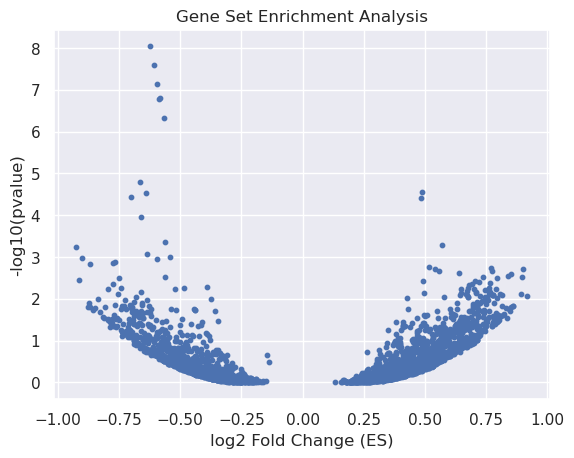

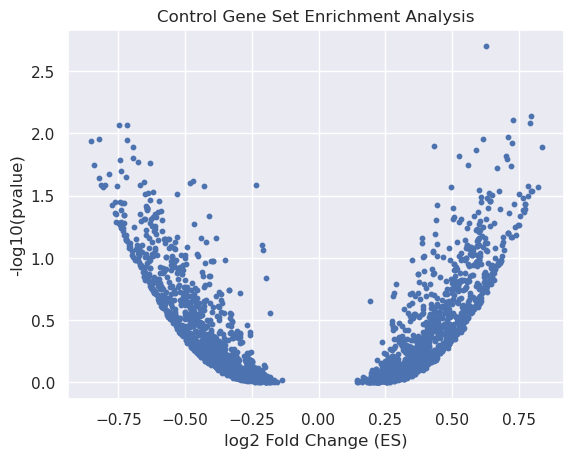

In [10]:
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['pval'].apply(lambda x:-np.log10(x)),s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Gene Set Enrichment Analysis')

plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['pval'].apply(lambda x:-np.log10(x)), s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Control Gene Set Enrichment Analysis')

In [11]:
# Using VAE generated data

pdf_path = pathlib.Path("../1.data-exploration/figures/gsea_plots.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

# Looping over each dataframe in all_signatures to generate gsea plots for the chosen geneset with data 
# from each latent dimension (1-100) and saving the plots to a singular pdf
for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "mitochondrial translational elongation (GO:0070125)"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = pathlib.Path("../1.data-exploration/figures/ctrl_gsea_plots.pdf")
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

# Looping over each dataframe in negative_control to generate gsea plots for the chosen geneset with data 
# from each latent dimension (1-100) and saving the plots to a singular pdf
for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "mitochondrial translational elongation (GO:0070125)"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()